In [15]:
# Import Library
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt as opt
import pandas_datareader.data as web
import fix_yahoo_finance as yf
from pandas import DataFrame
from bs4 import BeautifulSoup
from datetime import datetime
from cvxopt import matrix, blas, solvers
yf.pdr_override()
%matplotlib inline

######################################################################

# Start, End date for stock price import
# Split date for training & test set
START = datetime(2016, 1, 1)
END = datetime.today().utcnow()
SPLIT = datetime(2017, 12, 31)

In [16]:
# List of stocks
symbols_list = ['AAPL','ABBV','ABT','ACN','AGN','AIG','ALL','AMGN','AMZN','AXP','BA','BAC','BIIB',
                'BK','BLK','BMY','BRK-B','C','CELG','CL','CMCSA','COF','COP','COST','CSCO','CVS','CVX',
                'DIS','DUK','DWDP','EMR','EXC','F','FB','FDX','FOX','FOXA','GD',
                'GE','GILD','GM','GOOGL','GS','HAL','HD','HON','IBM','INTC','JNJ','JPM','KHC','KMI','KO',
                'LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MON','MRK','MS','MSFT','NEE','NKE',
                'ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB','SO','SPG','T','TGT',
                'TWX','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','WMT','XOM','SPY']
bmk = 'SPY' # Benchmark
stocks = symbols_list.copy()
stocks.remove(bmk)

In [37]:
# Import historical stock price from yahoo finance
symbols = pd.DataFrame()
for ticker in symbols_list:
    r = web.get_data_yahoo(ticker, START, END)['Adj Close']
    symbols = pd.concat([symbols, r], axis=1)
symbols.columns = symbols_list

[*********************100%***********************]  1 of 1 downloaded

In [38]:
# Check data
symbols.head()

,AAPL,ABBV,ABT,ACN,AGN,AIG,ALL,AMGN,AMZN,AXP,...,UPS,USB,UTX,V,VZ,WBA,WFC,WMT,XOM,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,101.014191,52.587296,40.536552,96.984177,302.181702,57.555096,58.223671,148.945862,636.989990,64.778854,...,88.563141,39.348419,90.436584,74.318314,40.872658,79.480690,49.183125,57.875557,71.344215,192.270966
2016-01-05,98.482849,52.368217,40.527103,97.488953,303.420044,57.755108,58.089314,148.785980,633.789978,63.782127,...,89.440941,39.538147,90.578545,74.877914,41.434025,77.394386,49.164532,59.250404,71.952095,192.596176
2016-01-06,96.555565,52.377342,40.187176,97.298477,298.230865,56.907444,57.436741,147.421997,632.650024,62.010929,...,88.170944,38.940525,88.118195,73.896164,41.059685,76.207664,48.225685,59.843666,71.353432,190.166733
2016-01-07,92.480484,52.222164,39.224045,94.441238,297.936005,55.545475,56.083591,143.903870,607.940002,61.452621,...,86.471405,38.200603,86.963722,72.443184,40.834179,77.681473,46.849926,61.237350,70.211327,185.604340
2016-01-08,92.969498,50.798180,38.402554,93.526917,294.309509,54.716869,55.882061,141.768524,607.049988,61.250477,...,85.341484,37.659893,85.544296,71.549782,40.437298,77.566643,46.069088,59.834251,68.792915,183.567032


In [39]:
# Calculate return and slice data into stocks, benchmark, training set, test set
all_rets = symbols.pct_change()
all_rets = all_rets.dropna()
all_train = all_rets[:SPLIT]
all_test = all_rets[SPLIT:]

rets_train = all_train.drop(bmk,1)
rets_test = all_test.drop(bmk,1)

bmk_rets_train = all_train[[bmk]]
bmk_rets_test = all_test[[bmk]]

# Transpose
rets_train = rets_train.transpose()
rets_test = rets_test.transpose()

In [40]:
# Check training set data
rets_train.head()

Date,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-19 00:00:00,...,2017-12-15 00:00:00,2017-12-18 00:00:00,2017-12-19 00:00:00,2017-12-20 00:00:00,2017-12-21 00:00:00,2017-12-22 00:00:00,2017-12-26 00:00:00,2017-12-27 00:00:00,2017-12-28 00:00:00,2017-12-29 00:00:00
AAPL,-0.025059,-0.019570,-0.042205,0.005288,0.016192,0.014513,-0.025710,0.021871,-0.024015,-0.004839,...,0.010161,0.014083,-0.010656,-0.001089,0.003785,0.000000,-0.025370,0.000176,0.002814,-0.010814
ABBV,-0.004166,0.000174,-0.002963,-0.027268,-0.031806,0.017817,-0.056938,0.066042,0.050953,-0.040984,...,0.011942,0.007594,-0.002750,-0.005208,0.005133,0.003064,-0.004684,0.003478,-0.003058,-0.011044
ABT,-0.000233,-0.008388,-0.023966,-0.020944,0.001475,0.017923,-0.022330,0.020357,-0.013625,-0.002713,...,0.014069,0.016216,0.007092,0.003873,-0.001578,0.000000,0.001230,0.008246,-0.000174,-0.006787
ACN,0.005205,-0.001954,-0.029366,-0.009681,0.010489,0.017938,-0.017325,0.026395,-0.025618,0.021255,...,0.009589,-0.006157,0.003296,-0.003088,0.016145,-0.002010,-0.005848,0.002157,0.001631,-0.003126
AGN,0.004098,-0.017102,-0.000989,-0.012172,-0.000301,-0.011157,-0.029389,0.041033,-0.012971,-0.011685,...,0.004329,-0.004485,-0.007840,-0.022764,0.011587,-0.016286,-0.002790,0.006872,-0.005738,-0.006318


In [41]:
cov_train = np.cov(rets_train) # Covariance
mean_train = np.mean(rets_train,1) # Mean
return_vec = rets_train.values # Convert to numpy array
n_assets = np.shape(rets_train)[0] # NUMBER OF ASSETS
max_weight = 0.5 # Maximum weight per stock in an optimal portfolio

In [42]:
# Functions used in portfolio optimization
def convert_portfolios(portfolios):
    ''' Takes in a cvxopt matrix of portfolios, returns list '''
    port_list = []
    for portfolio in portfolios:
        temp = np.array(portfolio).T
        port_list.append(temp[0].tolist())
        
    return port_list

def optimal_portfolio(returns):
    ''' returns an optimal portfolio given a matrix of returns '''
    n = len(returns)
    #print n  # n=4, number of assets
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))  #S is the covariance matrix. diagonal is the variance of each stock

    
    pbar = opt.matrix(np.mean(returns, axis=1))
    print("pbar:", pbar)

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    h = opt.matrix(np.append(h,max_weight*np.ones((n,1)), axis = 0)) # max weight
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]

    port_list = convert_portfolios(portfolios)
 
   
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]  #Different than input returns
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] #np.sqrt returns the stdev, not variance
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    print("wt, optimal portfolio:", wt)
    return np.asarray(wt), returns, risks, port_list

def covmean_portfolio(covariances, mean_returns):
    ''' returns an optimal portfolio given a covariance matrix and matrix of mean returns '''
    n = len(mean_returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] # range of mu used in plotting efficient frontier
    mu_target = 0.0015
    
    S = opt.matrix(covariances)

    pbar = opt.matrix(mean_returns)

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    G = opt.matrix(np.append(G,np.eye((n)), axis = 0))
    h = opt.matrix(0.0, (n ,1))
    h = opt.matrix(np.append(h,max_weight*np.ones((n,1)), axis = 0)) # max weight
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    port_list = convert_portfolios(portfolios)
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    frontier_returns = [blas.dot(pbar, x) for x in portfolios]  
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] 
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(S*mu_target, -pbar, G, h, A, b)['x']

    return np.asarray(wt), frontier_returns, risks, port_list

In [43]:
# Run an optimization
weights, returns, risks, portfolios = covmean_portfolio(cov_train, mean_train)

     pcost       dcost       gap    pres   dres
 0: -6.7059e-04 -4.9022e+01  5e+01  1e-15  2e-15
 1: -6.7089e-04 -5.2411e-01  5e-01  2e-16  2e-15
 2: -6.9643e-04 -3.6352e-02  4e-02  2e-16  2e-16
 3: -9.9606e-04 -2.0853e-02  2e-02  3e-15  3e-17
 4: -1.0684e-03 -2.4449e-03  1e-03  3e-16  2e-17
 5: -1.3871e-03 -2.1039e-03  7e-04  2e-16  1e-17
 6: -1.6406e-03 -1.7480e-03  1e-04  2e-16  4e-18
 7: -1.6392e-03 -1.6734e-03  3e-05  3e-16  3e-18
 8: -1.6557e-03 -1.6561e-03  3e-07  2e-16  4e-18
 9: -1.6559e-03 -1.6559e-03  3e-09  9e-16  5e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.7033e-04 -4.9022e+01  5e+01  1e-15  2e-15
 1: -6.7063e-04 -5.2411e-01  5e-01  4e-16  2e-15
 2: -6.9617e-04 -3.6348e-02  4e-02  2e-16  2e-16
 3: -9.9565e-04 -2.0849e-02  2e-02  4e-15  3e-17
 4: -1.0680e-03 -2.4441e-03  1e-03  4e-16  2e-17
 5: -1.3869e-03 -2.1025e-03  7e-04  3e-16  9e-18
 6: -1.6397e-03 -1.7466e-03  1e-04  2e-16  5e-18
 7: -1.6387e-03 -1.6722e-03  3e-05  2e-16  5e-1

     pcost       dcost       gap    pres   dres
 0: -6.5953e-04 -4.9022e+01  5e+01  4e-15  2e-15
 1: -6.5983e-04 -5.2395e-01  5e-01  2e-16  2e-15
 2: -6.8520e-04 -3.6214e-02  4e-02  2e-16  1e-16
 3: -9.7855e-04 -2.0686e-02  2e-02  4e-15  3e-17
 4: -1.0493e-03 -2.4068e-03  1e-03  3e-16  2e-17
 5: -1.3766e-03 -2.0429e-03  7e-04  2e-16  9e-18
 6: -1.6010e-03 -1.6890e-03  9e-05  2e-16  4e-18
 7: -1.6146e-03 -1.6243e-03  1e-05  2e-16  4e-18
 8: -1.6191e-03 -1.6192e-03  1e-07  3e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.5793e-04 -4.9022e+01  5e+01  6e-15  2e-15
 1: -6.5823e-04 -5.2393e-01  5e-01  2e-16  2e-15
 2: -6.8357e-04 -3.6194e-02  4e-02  2e-16  1e-16
 3: -9.7604e-04 -2.0662e-02  2e-02  4e-16  3e-17
 4: -1.0465e-03 -2.4013e-03  1e-03  2e-16  2e-17
 5: -1.3750e-03 -2.0340e-03  7e-04  3e-16  1e-17
 6: -1.5954e-03 -1.6808e-03  9e-05  2e-16  4e-18
 7: -1.6100e-03 -1.6182e-03  8e-06  2e-16  3e-18
 8: -1.6138e-03 -1.6139e-03  8e-08  2e-16  4e-1

 4: -6.9163e-04 -1.6358e-03  9e-04  7e-16  2e-17
 5: -9.6923e-04 -1.2283e-03  3e-04  2e-16  4e-18
 6: -1.0251e-03 -1.0454e-03  2e-05  9e-16  4e-18
 7: -1.0321e-03 -1.0323e-03  2e-07  9e-16  3e-18
 8: -1.0322e-03 -1.0322e-03  2e-09  6e-16  3e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0600e-04 -4.9021e+01  5e+01  8e-15  1e-15
 1: -3.0632e-04 -5.1872e-01  5e-01  5e-16  2e-15
 2: -3.3469e-04 -3.1423e-02  3e-02  5e-16  1e-16
 3: -6.2404e-04 -1.4046e-02  1e-02  4e-16  2e-17
 4: -6.8483e-04 -1.5749e-03  9e-04  4e-16  1e-17
 5: -9.3010e-04 -1.1661e-03  2e-04  2e-16  3e-18
 6: -9.8619e-04 -1.0003e-03  1e-05  2e-16  4e-18
 7: -9.9188e-04 -9.9204e-04  2e-07  2e-16  3e-18
 8: -9.9194e-04 -9.9195e-04  2e-09  2e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.6176e-04 -4.9021e+01  5e+01  5e-15  1e-15
 1: -2.6210e-04 -5.2081e-01  5e-01  2e-16  2e-15
 2: -2.9170e-04 -3.2841e-02  3e-02  6e-16  1e-16
 3: -5.5283e-04 -1.4179

 8:  2.8886e-03  2.8886e-03  3e-08  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.2719e-03 -4.9286e+01  5e+01  1e-15  1e-15
 1:  6.2456e-03 -8.0257e-01  8e-01  2e-16  2e-15
 2:  5.5546e-03 -2.3576e-02  3e-02  4e-16  5e-17
 3:  4.6734e-03 -2.5656e-03  7e-03  2e-16  4e-17
 4:  3.8211e-03  1.9083e-03  2e-03  2e-16  2e-17
 5:  3.4596e-03  3.0873e-03  4e-04  4e-16  2e-17
 6:  3.3543e-03  3.3064e-03  5e-05  2e-16  2e-17
 7:  3.3374e-03  3.3358e-03  2e-06  8e-16  2e-17
 8:  3.3367e-03  3.3367e-03  5e-08  2e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.9938e-03 -4.9317e+01  5e+01  1e-16  1e-15
 1:  6.9629e-03 -8.2963e-01  8e-01  3e-16  2e-15
 2:  6.2856e-03 -2.7983e-02  3e-02  2e-16  6e-17
 3:  5.3347e-03 -2.9730e-03  8e-03  1e-16  4e-17
 4:  4.3950e-03  2.1625e-03  2e-03  3e-16  3e-17
 5:  3.9839e-03  3.5236e-03  5e-04  1e-16  2e-17
 6:  3.8593e-03  3.8010e-03  6e-05  3e-16  2e-17
 7:  3.8387e-03  3.8365

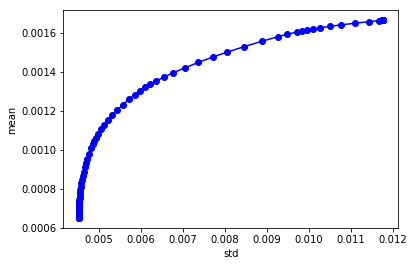

In [44]:
# Efficient Frontier
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'b-o') #risks and returns are just arrays of points along the frontier
plt.show()

In [47]:
# All optimal portfolios at a given risk
all_portfolios = pd.DataFrame(data=portfolios, columns=stocks)
all_portfolios2 = all_portfolios.transpose()
pd.options.display.float_format = '{:,.8f}'.format
all_portfolios2.sort_values(by=[0],ascending=False).head() # Sort by maximum weight in a lowest risk portfolio

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
PYPL,0.49999956,0.49999967,0.49999976,0.49999983,0.49999990,0.49999994,0.49999997,0.49999998,0.49999998,0.49999997,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
BA,0.49999835,0.49999829,0.49999826,0.49999824,0.49999825,0.49999827,0.49999833,0.49999840,0.49999850,0.49999861,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
TXN,0.00000014,0.00000014,0.00000014,0.00000014,0.00000014,0.00000014,0.00000014,0.00000014,0.00000014,0.00000014,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
UNH,0.00000006,0.00000006,0.00000006,0.00000006,0.00000006,0.00000006,0.00000006,0.00000005,0.00000005,0.00000005,...,0.00000005,0.00000003,0.00000003,0.00000003,0.00000002,0.00000002,0.00000001,0.00000001,0.00000001,0.00000001
BAC,0.00000006,0.00000006,0.00000005,0.00000005,0.00000005,0.00000005,0.00000005,0.00000005,0.00000005,0.00000004,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [49]:
# Select optimal portfolio at target risk (mu)
optimal = pd.DataFrame(data=weights, index=stocks)
optimal.columns = ['Weights']
optimal2 = optimal.sort_values(by='Weights', ascending=False)
pd.options.display.float_format = '{:,.8f}'.format
optimal2.head()

,Weights
PYPL,0.49999971
BA,0.49999717
TXN,0.00000017
UNH,0.00000007
BAC,0.00000007


In [50]:
weight = np.round(optimal, 2)
weight = weight.dropna()
weight = weight.T
weight = weight.dropna()

# Historical return in a test period
price = pd.DataFrame(data=rets_test.T, columns=stocks)
stocks = pd.DataFrame(np.dot(price,weight.T),index=price.index)

# Historical benchmark return in a test period
bmk = pd.DataFrame(data=bmk_rets_test)
result = pd.concat([stocks, bmk], axis=1)

# Check performance using cumulative return
result = 1 + result
pfm = result.cumprod(axis = 0)
pfm.rename(columns={0:'portfolio'}, inplace=True)
pfm = pfm*100

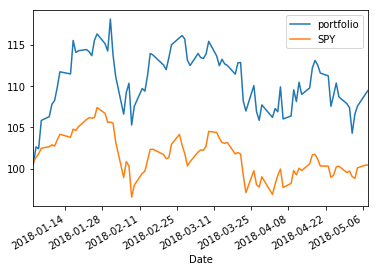

In [51]:
pfm.plot()